# 論文ラベルごとの頻出単語分析

論文のラベル（Primary, Secondary, Missing）ごとに頻出単語を分析し、特徴的な単語を抽出します。

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from pathlib import Path
import re
from collections import Counter, defaultdict
import fitz  # PyMuPDF
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)

# Set up plotting
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
japanize_matplotlib.japanize()
%matplotlib inline

## 1. データの読み込み

In [ ]:
# Load training labels
train_labels = pd.read_csv('../dataset/train_labels.csv')
print(f"Training labels shape: {train_labels.shape}")
print("\nLabel distribution:")
print(train_labels['type'].value_counts())
print(f"\nPercentages:")
print((train_labels['type'].value_counts() / len(train_labels) * 100).round(2))

In [ ]:
# Set up data paths
train_dir = Path('../dataset/train')
pdf_dir = train_dir / 'PDF'

print(f"PDF files: {len(list(pdf_dir.glob('*.pdf'))) if pdf_dir.exists() else 0}")

## 2. テキスト抽出関数の定義

In [49]:
def extract_text_from_pdf(pdf_path):
    """PDFファイルからテキストを抽出"""
    try:
        # PyMuPDFでPDFを開く（アノテーションエラーを抑制）
        doc = fitz.open(pdf_path)
        text_parts = []
        
        # 各ページからテキストを抽出
        for page_num in range(len(doc)):
            try:
                page = doc.load_page(page_num)
                # アノテーションエラーを回避するため、シンプルなテキスト抽出を使用
                text = page.get_text("text", flags=fitz.TEXTFLAGS_TEXT)
                if text.strip():  # 空でない場合のみ追加
                    text_parts.append(text)
            except Exception as page_error:
                # ページレベルのエラーをスキップして次のページを処理
                print(f"Warning: Error processing page {page_num} in {pdf_path}: {page_error}")
                continue
        
        doc.close()
        return ' '.join(text_parts)
    
    except Exception as e:
        print(f"Error processing {pdf_path}: {e}")
        return ""

def preprocess_text(text):
    """テキストの前処理"""
    if not text:
        return []
    
    # 小文字化
    text = text.lower()
    
    # 数字、特殊文字を除去
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # トークン化
    tokens = word_tokenize(text)
    
    # ストップワード除去
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    # レンマ化
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

## 3. 論文からテキストを抽出してラベル別に分類

In [50]:
# ラベル別のテキストを格納する辞書
label_texts = {
    'Primary': [],
    'Secondary': [],
    'Missing': []
}

# 各論文のテキストを抽出
processed_count = 0

for _, row in train_labels.iterrows():
    article_id = row['article_id']
    label = row['type']
    
    # PDFファイルのパスを構築
    pdf_path = pdf_dir / f"{article_id}.pdf"
    
    if pdf_path.exists():
        text = extract_text_from_pdf(pdf_path)
        if text:
            label_texts[label].append(text)
            processed_count += 1

print(f"\nTotal processed articles: {processed_count}")
print("\nTexts per label:")
for label, texts in label_texts.items():
    print(f"  {label}: {len(texts)} articles")

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: unsupported error: cannot create appearance stream for  annotations

MuPDF error: uns

## 4. ラベル別の単語頻度分析

In [51]:
# ラベル別の単語カウント
label_word_counts = {}
label_vocabularies = {}

for label, texts in label_texts.items():
    print(f"\nProcessing {label} articles...")
    
    all_words = []
    for text in texts:
        words = preprocess_text(text)
        all_words.extend(words)
    
    # 単語頻度を計算
    word_counts = Counter(all_words)
    label_word_counts[label] = word_counts
    label_vocabularies[label] = set(all_words)
    
    print(f"  Total words: {len(all_words):,}")
    print(f"  Unique words: {len(word_counts):,}")
    print(f"  Top 10 words: {word_counts.most_common(10)}")


Processing Primary articles...
  Total words: 1,408,894
  Unique words: 69,843
  Top 10 words: [('data', 8453), ('model', 5677), ('fig', 5126), ('study', 4997), ('using', 4939), ('specie', 4868), ('analysis', 4463), ('figure', 4354), ('cell', 4338), ('doi', 3749)]

Processing Secondary articles...
  Total words: 2,752,945
  Unique words: 37,767
  Top 10 words: [('gene', 16819), ('protein', 16583), ('data', 16355), ('using', 11995), ('genome', 11956), ('cell', 11848), ('alaska', 11327), ('analysis', 11272), ('specie', 11203), ('strain', 10375)]

Processing Missing articles...
  Total words: 1,357,424
  Unique words: 107,885
  Top 10 words: [('gene', 9459), ('data', 6318), ('cell', 6180), ('study', 5513), ('analysis', 5288), ('using', 4925), ('fig', 4763), ('file', 4232), ('additional', 4135), ('model', 3942)]


## 5. 頻出単語の可視化

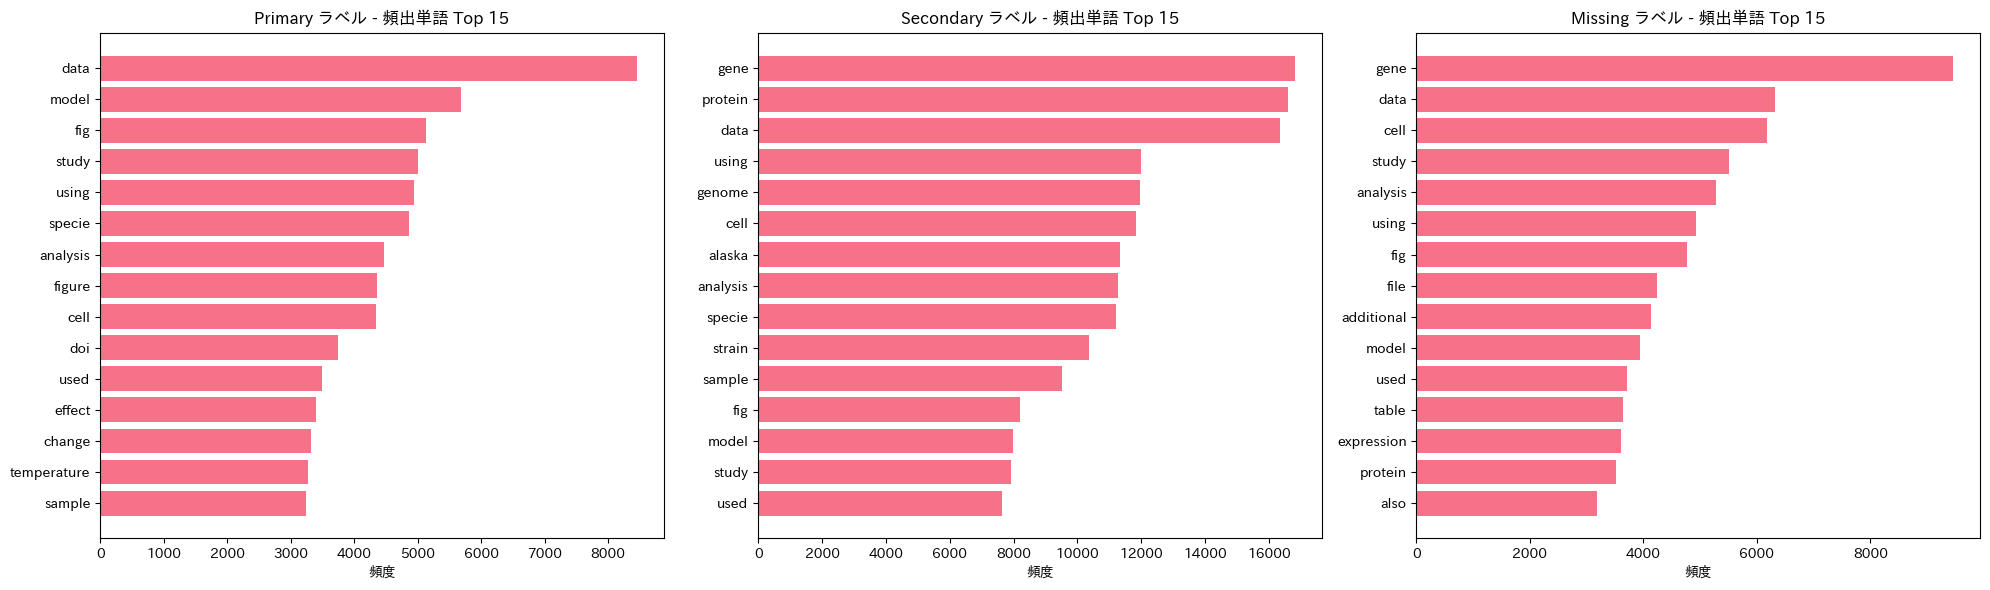

In [52]:
# 各ラベルの頻出単語を棒グラフで可視化
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (label, word_counts) in enumerate(label_word_counts.items()):
    if len(word_counts) > 0:
        top_words = word_counts.most_common(15)
        words, counts = zip(*top_words)
        
        axes[i].barh(range(len(words)), counts)
        axes[i].set_yticks(range(len(words)))
        axes[i].set_yticklabels(words)
        axes[i].set_xlabel('頻度')
        axes[i].set_title(f'{label} ラベル - 頻出単語 Top 15')
        axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

## 6. ワードクラウドの作成

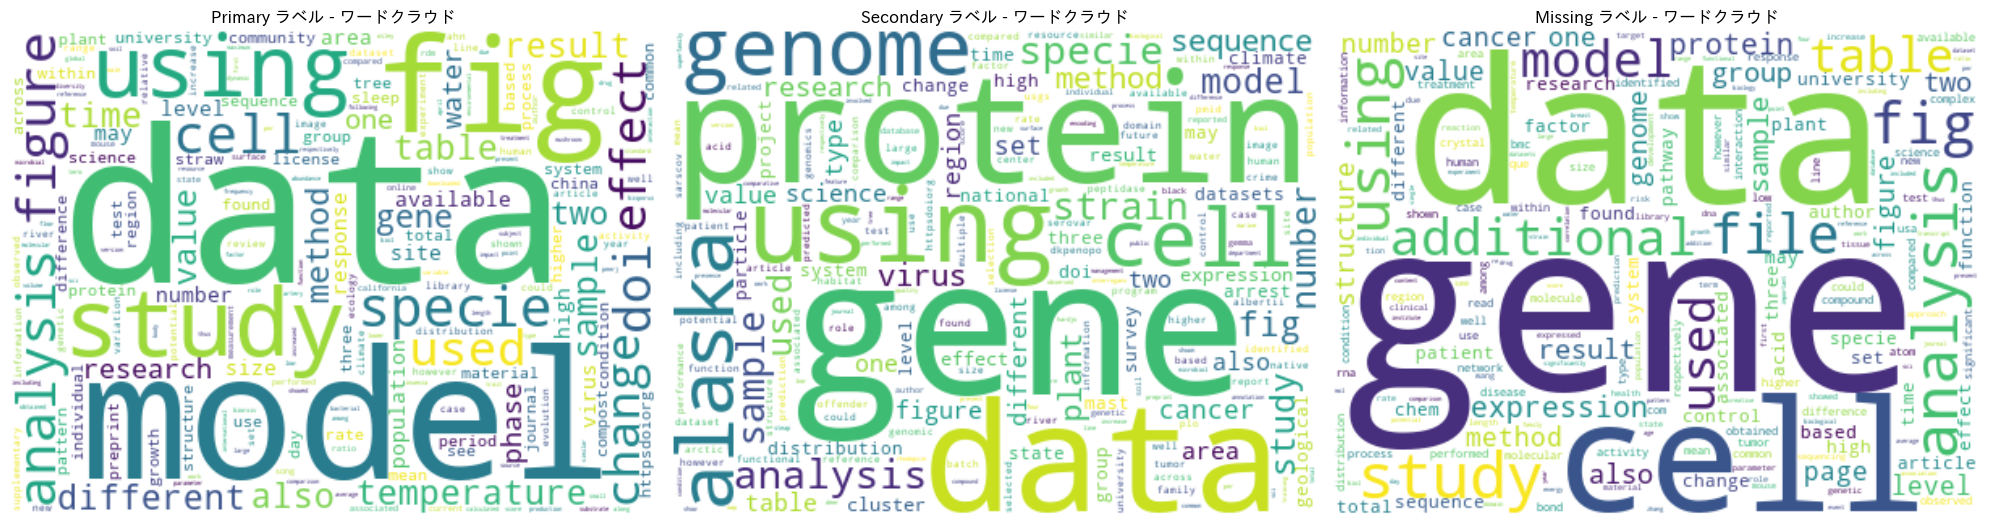

In [53]:
# 各ラベルのワードクラウドを作成
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (label, word_counts) in enumerate(label_word_counts.items()):
    if len(word_counts) > 0:
        # ワードクラウドの作成
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(word_counts)
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{label} ラベル - ワードクラウド')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

## 7. ラベル間の特徴的な単語の分析

In [54]:
# TF-IDFスコアを計算して特徴的な単語を抽出
from sklearn.feature_extraction.text import TfidfVectorizer

# 各ラベルの全テキストを結合
label_documents = {}
for label, texts in label_texts.items():
    if texts:
        # 前処理済みのテキストを結合
        processed_texts = [' '.join(preprocess_text(text)) for text in texts]
        label_documents[label] = ' '.join(processed_texts)

# TF-IDFベクトライザーを作成
if label_documents:
    documents = list(label_documents.values())
    labels = list(label_documents.keys())
    
    vectorizer = TfidfVectorizer(max_features=1000, min_df=2)
    tfidf_matrix = vectorizer.fit_transform(documents)
    
    # 特徴語の抽出
    feature_names = vectorizer.get_feature_names_out()
    
    # 各ラベルの特徴的な単語を抽出
    for i, label in enumerate(labels):
        # TF-IDFスコアを取得
        tfidf_scores = tfidf_matrix[i].toarray()[0]
        
        # スコアでソート
        word_scores = list(zip(feature_names, tfidf_scores))
        word_scores.sort(key=lambda x: x[1], reverse=True)
        
        print(f"\n=== {label} ラベルの特徴的な単語 (TF-IDF) ===")
        for word, score in word_scores[:20]:
            print(f"  {word}: {score:.4f}")


=== Primary ラベルの特徴的な単語 (TF-IDF) ===
  data: 0.2739
  model: 0.1840
  fig: 0.1661
  study: 0.1619
  using: 0.1601
  specie: 0.1578
  analysis: 0.1446
  figure: 0.1411
  cell: 0.1406
  doi: 0.1215
  used: 0.1130
  effect: 0.1100
  change: 0.1075
  temperature: 0.1061
  sample: 0.1048
  also: 0.1048
  table: 0.1036
  different: 0.1011
  time: 0.0997
  result: 0.0988

=== Secondary ラベルの特徴的な単語 (TF-IDF) ===
  gene: 0.2423
  protein: 0.2389
  data: 0.2356
  using: 0.1728
  genome: 0.1723
  cell: 0.1707
  alaska: 0.1632
  analysis: 0.1624
  specie: 0.1614
  strain: 0.1495
  sample: 0.1371
  fig: 0.1181
  model: 0.1152
  study: 0.1140
  used: 0.1099
  number: 0.1081
  sequence: 0.0953
  method: 0.0953
  plant: 0.0914
  virus: 0.0912

=== Missing ラベルの特徴的な単語 (TF-IDF) ===
  gene: 0.3166
  data: 0.2115
  cell: 0.2068
  study: 0.1845
  analysis: 0.1770
  using: 0.1648
  fig: 0.1594
  file: 0.1416
  additional: 0.1384
  model: 0.1319
  used: 0.1239
  table: 0.1216
  expression: 0.1207
  protein: 0.1

## 8. ラベル間の語彙の重複分析

In [55]:
# 語彙の重複を分析
if len(label_vocabularies) >= 2:
    print("=== 語彙の重複分析 ===")
    
    # 各ラベルの語彙サイズ
    for label, vocab in label_vocabularies.items():
        print(f"{label}: {len(vocab):,} unique words")
    
    # ペアワイズの重複を計算
    labels = list(label_vocabularies.keys())
    print("\n=== ラベル間の語彙重複 ===")
    
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            label1, label2 = labels[i], labels[j]
            vocab1, vocab2 = label_vocabularies[label1], label_vocabularies[label2]
            
            intersection = vocab1 & vocab2
            union = vocab1 | vocab2
            
            jaccard = len(intersection) / len(union) if union else 0
            
            print(f"{label1} vs {label2}:")
            print(f"  共通語彙: {len(intersection):,}")
            print(f"  Jaccard係数: {jaccard:.4f}")
            print(f"  重複率 ({label1}): {len(intersection)/len(vocab1)*100:.2f}%")
            print(f"  重複率 ({label2}): {len(intersection)/len(vocab2)*100:.2f}%")
            print()

=== 語彙の重複分析 ===
Primary: 69,843 unique words
Secondary: 37,767 unique words
Missing: 107,885 unique words

=== ラベル間の語彙重複 ===
Primary vs Secondary:
  共通語彙: 21,581
  Jaccard係数: 0.2509
  重複率 (Primary): 30.90%
  重複率 (Secondary): 57.14%

Primary vs Missing:
  共通語彙: 28,398
  Jaccard係数: 0.1902
  重複率 (Primary): 40.66%
  重複率 (Missing): 26.32%

Secondary vs Missing:
  共通語彙: 18,767
  Jaccard係数: 0.1479
  重複率 (Secondary): 49.69%
  重複率 (Missing): 17.40%



## 9. ラベル別の語彙統計

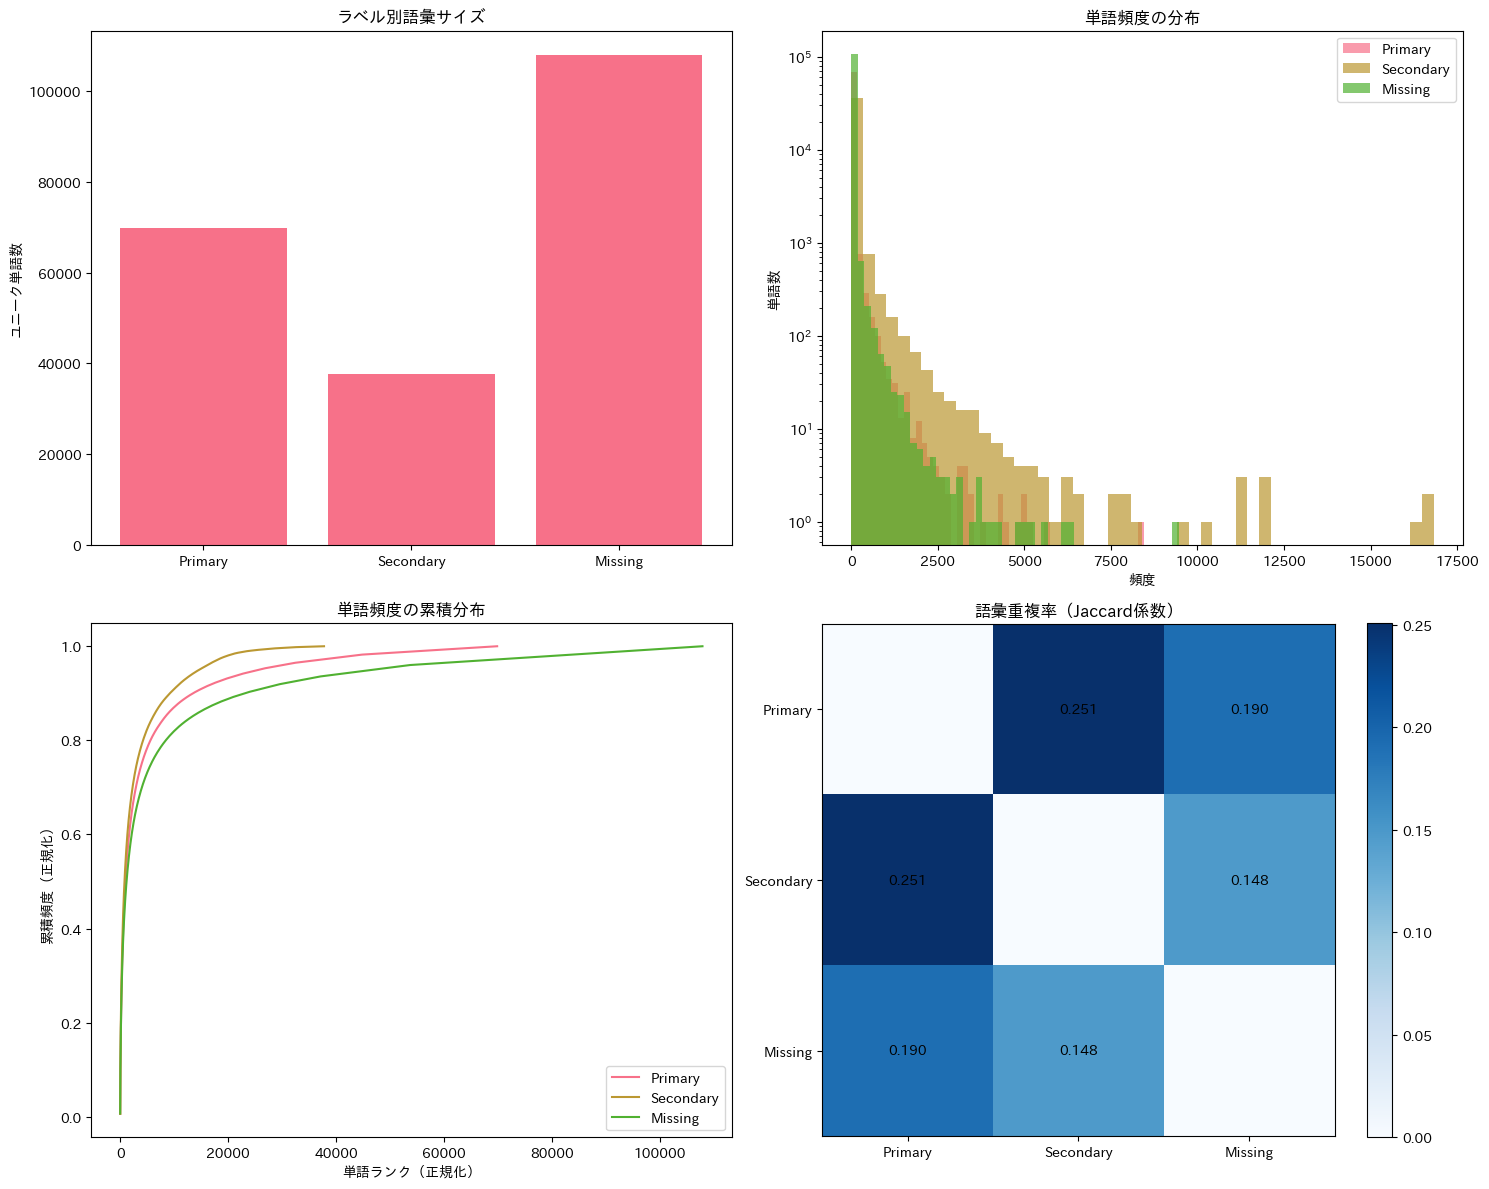

In [56]:
# 語彙統計の可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 語彙サイズの比較
labels = list(label_vocabularies.keys())
vocab_sizes = [len(vocab) for vocab in label_vocabularies.values()]

axes[0, 0].bar(labels, vocab_sizes)
axes[0, 0].set_title('ラベル別語彙サイズ')
axes[0, 0].set_ylabel('ユニーク単語数')

# 2. 単語頻度の分布
for i, (label, word_counts) in enumerate(label_word_counts.items()):
    if len(word_counts) > 0:
        frequencies = list(word_counts.values())
        axes[0, 1].hist(frequencies, bins=50, alpha=0.7, label=label)

axes[0, 1].set_title('単語頻度の分布')
axes[0, 1].set_xlabel('頻度')
axes[0, 1].set_ylabel('単語数')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()

# 3. 高頻度語の累積分布
for i, (label, word_counts) in enumerate(label_word_counts.items()):
    if len(word_counts) > 0:
        frequencies = sorted(word_counts.values(), reverse=True)
        cumulative = np.cumsum(frequencies)
        axes[1, 0].plot(cumulative/cumulative[-1], label=label)

axes[1, 0].set_title('単語頻度の累積分布')
axes[1, 0].set_xlabel('単語ランク（正規化）')
axes[1, 0].set_ylabel('累積頻度（正規化）')
axes[1, 0].legend()

# 4. 語彙の重複関係（ベン図風）
if len(label_vocabularies) >= 2:
    overlap_matrix = np.zeros((len(labels), len(labels)))
    
    for i, label1 in enumerate(labels):
        for j, label2 in enumerate(labels):
            if i != j:
                vocab1, vocab2 = label_vocabularies[label1], label_vocabularies[label2]
                overlap = len(vocab1 & vocab2) / len(vocab1 | vocab2)
                overlap_matrix[i, j] = overlap
    
    im = axes[1, 1].imshow(overlap_matrix, cmap='Blues')
    axes[1, 1].set_xticks(range(len(labels)))
    axes[1, 1].set_yticks(range(len(labels)))
    axes[1, 1].set_xticklabels(labels)
    axes[1, 1].set_yticklabels(labels)
    axes[1, 1].set_title('語彙重複率（Jaccard係数）')
    
    # 数値を表示
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i != j:
                axes[1, 1].text(j, i, f'{overlap_matrix[i, j]:.3f}', 
                               ha='center', va='center')
    
    plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

## 10. 結果の要約と考察

In [57]:
print("=== 分析結果の要約 ===")

print("\n1. 処理した論文数:")
for label, texts in label_texts.items():
    print(f"   {label}: {len(texts)} 論文")

print("\n2. 語彙統計:")
for label, vocab in label_vocabularies.items():
    total_words = sum(label_word_counts[label].values())
    unique_words = len(vocab)
    print(f"   {label}:")
    print(f"     総単語数: {total_words:,}")
    print(f"     ユニーク単語数: {unique_words:,}")
    print(f"     語彙多様性: {unique_words/total_words:.4f}")

print("\n3. 各ラベルの特徴的な単語（頻度上位5位）:")
for label, word_counts in label_word_counts.items():
    if len(word_counts) > 0:
        top_words = word_counts.most_common(5)
        print(f"   {label}: {[word for word, count in top_words]}")

=== 分析結果の要約 ===

1. 処理した論文数:
   Primary: 270 論文
   Secondary: 449 論文
   Missing: 309 論文

2. 語彙統計:
   Primary:
     総単語数: 1,408,894
     ユニーク単語数: 69,843
     語彙多様性: 0.0496
   Secondary:
     総単語数: 2,752,945
     ユニーク単語数: 37,767
     語彙多様性: 0.0137
   Missing:
     総単語数: 1,357,424
     ユニーク単語数: 107,885
     語彙多様性: 0.0795

3. 各ラベルの特徴的な単語（頻度上位5位）:
   Primary: ['data', 'model', 'fig', 'study', 'using']
   Secondary: ['gene', 'protein', 'data', 'using', 'genome']
   Missing: ['gene', 'data', 'cell', 'study', 'analysis']
